In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Importing Libraries
### Importing Data sets

In [34]:
dim_date = pd.read_csv(r"C:\Users\hrishi\Downloads\New folder (7)\source-code\3_project_hospitality_analysis\datasets\dim_date.csv")
dim_hotels=pd.read_csv(r"C:\Users\hrishi\Downloads\New folder (7)\source-code\3_project_hospitality_analysis\datasets\dim_hotels.csv")
dim_rooms=pd.read_csv(r"C:\Users\hrishi\Downloads\New folder (7)\source-code\3_project_hospitality_analysis\datasets\dim_rooms.csv")
fact_agg_bookings=pd.read_csv(r"C:\Users\hrishi\Downloads\New folder (7)\source-code\3_project_hospitality_analysis\datasets\fact_aggregated_bookings.csv")
fact_bookings=pd.read_csv(r"C:\Users\hrishi\Downloads\New folder (7)\source-code\3_project_hospitality_analysis\datasets\fact_bookings.csv")

### Data Exploration

In [35]:
dim_date.head()

,date,mmm yy,week no,day_type
0,01-May-22,May 22,W 19,weekend
1,02-May-22,May 22,W 19,weekeday
2,03-May-22,May 22,W 19,weekeday
3,04-May-22,May 22,W 19,weekeday
4,05-May-22,May 22,W 19,weekeday


In [36]:
dim_hotels.head()

,property_id,property_name,category,city
0,16558,Atliq Grands,Luxury,Delhi
1,16559,Atliq Exotica,Luxury,Mumbai
2,16560,Atliq City,Business,Delhi
3,16561,Atliq Blu,Luxury,Delhi
4,16562,Atliq Bay,Luxury,Delhi


In [37]:
dim_rooms.head()

,room_id,room_class
0,RT1,Standard
1,RT2,Elite
2,RT3,Premium
3,RT4,Presidential


In [38]:
fact_agg_bookings.head()

,property_id,check_in_date,room_category,successful_bookings,capacity
0,16559,1-May-22,RT1,25,30.0
1,19562,1-May-22,RT1,28,30.0
2,19563,1-May-22,RT1,23,30.0
3,17558,1-May-22,RT1,30,19.0
4,16558,1-May-22,RT1,18,19.0


In [39]:
fact_bookings.head()

,booking_id,property_id,booking_date,check_in_date,checkout_date,no_guests,room_category,booking_platform,ratings_given,booking_status,revenue_generated,revenue_realized
0,May012216558RT11,16558,27-04-22,1/5/2022,2/5/2022,-3.0,RT1,direct online,1.0,Checked Out,10010,10010
1,May012216558RT12,16558,30-04-22,1/5/2022,2/5/2022,2.0,RT1,others,NaN,Cancelled,9100,3640
2,May012216558RT13,16558,28-04-22,1/5/2022,4/5/2022,2.0,RT1,logtrip,5.0,Checked Out,9100000,9100
3,May012216558RT14,16558,28-04-22,1/5/2022,2/5/2022,-2.0,RT1,others,NaN,Cancelled,9100,3640
4,May012216558RT15,16558,27-04-22,1/5/2022,2/5/2022,4.0,RT1,direct online,5.0,Checked Out,10920,10920


### Data cleaning and Transformation

Lets check if any of table has Null values or not

In [40]:
dim_date.isnull().sum()

date        0
mmm yy      0
week no     0
day_type    0
dtype: int64

In [41]:
dim_hotels.isnull().sum()

property_id      0
property_name    0
category         0
city             0
dtype: int64

In [42]:
dim_rooms.isnull().sum()

room_id       0
room_class    0
dtype: int64

In [43]:
fact_agg_bookings.isnull().sum() # We found 2 null values in Capacity column

property_id            0
check_in_date          0
room_category          0
successful_bookings    0
capacity               2
dtype: int64

In [44]:
# Replace Null with Mean value

In [45]:
mean_capacity = fact_agg_bookings["capacity"].mean()
fact_agg_bookings["capacity"] = fact_agg_bookings["capacity"].fillna(mean_capacity)
fact_agg_bookings.isnull().sum()

property_id            0
check_in_date          0
room_category          0
successful_bookings    0
capacity               0
dtype: int64

In [46]:
fact_bookings.isnull().sum() # Rating given can be null

booking_id               0
property_id              0
booking_date             0
check_in_date            0
checkout_date            0
no_guests                3
room_category            0
booking_platform         0
ratings_given        77907
booking_status           0
revenue_generated        0
revenue_realized         0
dtype: int64

In [47]:
fact_bookings.no_guests.describe()

count    134587.000000
mean          2.036170
std           1.034885
min         -17.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           6.000000
Name: no_guests, dtype: float64

We have negative values in no_guest column. no_guest should be >=0 Lets remove those rows. no_guest cannot be less than 0

In [48]:
fact_bookings = fact_bookings[fact_bookings.no_guests >=0]
fact_bookings.no_guests.describe()

count    134578.000000
mean          2.036744
std           1.031710
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           6.000000
Name: no_guests, dtype: float64

In [49]:
fact_bookings.revenue_generated.min(),fact_bookings.revenue_generated.max()

(np.int64(6500), np.int64(28560000))

We have max revenue of 28.5M which is clearly a outlier. so lets remove such outliers. We will use 3 step STD method for removing the outliers

In [50]:
avg, std= fact_bookings.revenue_generated.mean(),fact_bookings.revenue_generated.std()
high_rev_limit=avg+3*std
high_rev_limit # Revenue generated more than high_rev_limit are outliers

np.float64(294498.50173207896)

In [51]:
fact_bookings = fact_bookings[fact_bookings.revenue_generated <= high_rev_limit]
fact_bookings.revenue_generated.describe()


count    134573.000000
mean      14915.959776
std        6452.676164
min        6500.000000
25%        9900.000000
50%       13500.000000
75%       18000.000000
max       45220.000000
Name: revenue_generated, dtype: float64

In [52]:
# lets check outliers in revenue_realized
rev_limit=fact_bookings.revenue_realized.mean()+3*fact_bookings.revenue_realized.std()
rev_limit

np.float64(33479.358661845814)

In [53]:
# lets check the Data which are greater than rev_limit
fact_bookings[fact_bookings.revenue_realized > rev_limit]

,booking_id,property_id,booking_date,check_in_date,checkout_date,no_guests,room_category,booking_platform,ratings_given,booking_status,revenue_generated,revenue_realized
137,May012216559RT41,16559,27-04-22,1/5/2022,7/5/2022,4.0,RT4,others,NaN,Checked Out,38760,38760
139,May012216559RT43,16559,1/5/2022,1/5/2022,2/5/2022,6.0,RT4,tripster,3.0,Checked Out,45220,45220
143,May012216559RT47,16559,28-04-22,1/5/2022,3/5/2022,3.0,RT4,others,5.0,Checked Out,35530,35530
149,May012216559RT413,16559,24-04-22,1/5/2022,7/5/2022,5.0,RT4,logtrip,NaN,Checked Out,41990,41990
222,May012216560RT45,16560,30-04-22,1/5/2022,3/5/2022,5.0,RT4,others,3.0,Checked Out,34580,34580
...,...,...,...,...,...,...,...,...,...,...,...,...
134328,Jul312219560RT49,19560,31-07-22,31-07-22,2/8/2022,6.0,RT4,direct online,5.0,Checked Out,39900,39900
134331,Jul312219560RT412,19560,31-07-22,31-07-22,1/8/2022,6.0,RT4,others,2.0,Checked Out,39900,39900
134467,Jul312219562RT45,19562,28-07-22,31-07-22,1/8/2022,6.0,RT4,makeyourtrip,4.0,Checked Out,39900,39900
134474,Jul312219562RT412,19562,25-07-22,31-07-22,6/8/2022,5.0,RT4,direct offline,5.0,Checked Out,37050,37050


If we notice all the data which have revenue_realized > rev_limit has room_category "RT4" which is a predidential room_class so 33k seems 
normal.dim_rooms.head()

fact_bookings[fact_bookings.room_category=="RT4"].revenue_realized.describe()

Lets check the upper limit revenue for RT4 room type

In [54]:
#mean +3*std
rev_limit=23439+3*9048
rev_limit # RT4 revenue is less than the rev_limit for RT4. so their is no Outlier 

50583

## Data Analyis

### 1.What is the average occupancy rate in each of the room category

To calculate average occupancy rate we need to add a calculated column for occupancy percentage

In [55]:
# creating calculated column for occupancy percentage
if "successful_bookings" in fact_agg_bookings and "capacity" in fact_agg_bookings:
    fact_agg_bookings["occ_pct"] = (fact_agg_bookings["successful_bookings"] / fact_agg_bookings["capacity"]) * 100
# Apply rounding   
fact_agg_bookings["occ_pct"] = fact_agg_bookings["occ_pct"].apply(lambda x: round(x, 2))

fact_agg_bookings.head()


,property_id,check_in_date,room_category,successful_bookings,capacity,occ_pct
0,16559,1-May-22,RT1,25,30.0,83.33
1,19562,1-May-22,RT1,28,30.0,93.33
2,19563,1-May-22,RT1,23,30.0,76.67
3,17558,1-May-22,RT1,30,19.0,157.89
4,16558,1-May-22,RT1,18,19.0,94.74


In [56]:
# calculating Average occ_pct in each of the room_category
df_rooms = fact_agg_bookings.groupby("room_category")["occ_pct"].mean().round(2)
print(df_rooms)


room_category
RT1    58.23
RT2    58.04
RT3    58.03
RT4    59.30
Name: occ_pct, dtype: float64


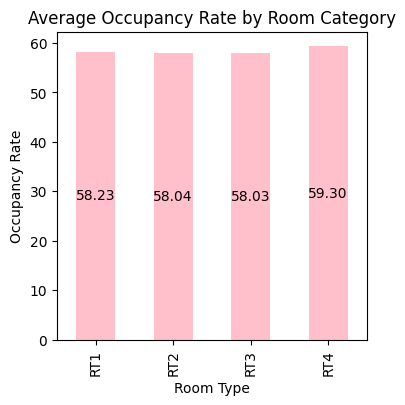

In [57]:
# plotting it in bar chart
plt.figure(figsize=(4,4))
df_rooms.plot(kind="bar", color="pink")
plt.title("Average Occupancy Rate by Room Category")
plt.xlabel("Room Type")
plt.ylabel("Occupancy Rate")

# Adding data labels
for index, value in enumerate(df_rooms):
    plt.text(index, value/2, f'{value:.2f}', ha="center", va="center", color="black", fontsize=10)

plt.show()


### 2. What is the average Occupancy rate by city

In [58]:
# we have to merge dim_hotel with fact_agg_bookings as dim_hotels contains city info 
df_city=pd.merge(fact_agg_bookings,dim_hotels,on="property_id")
df_city

df_city_avg= df_city.groupby("city")["occ_pct"].mean().round(2)
df_city_avg

city
Bangalore    56.59
Delhi        61.61
Hyderabad    58.14
Mumbai       57.94
Name: occ_pct, dtype: float64

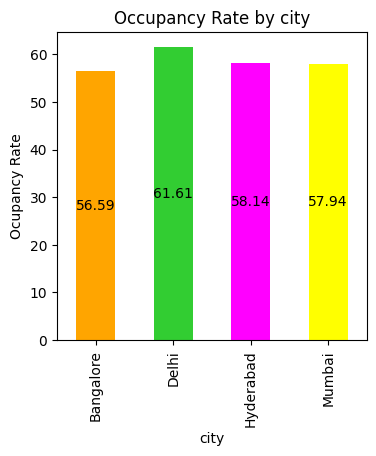

In [59]:
#plotting it in bar chart
plt.figure(figsize=(4,4))
df_city_avg.plot(kind="bar", color=["orange", "limegreen", "magenta", "yellow"])
plt.xlabel("city")
plt.ylabel("Ocupancy Rate")
plt.title("Occupancy Rate by city")


# Adding data labels
for index, values in enumerate(df_city_avg):
    plt.text(index, values / 2, f'{values:.2f}', ha="center", va="center", color="black", fontsize=10)

plt.show()


### 3. When was the occupancy rate better ? Weekdays or Weekend

In [60]:
#joining dim_date table as dim_date table contains day_type.
import pandas as pd


df_dtype = pd.merge(fact_agg_bookings, dim_date, left_on="check_in_date", right_on="date")


df_dtype_avg = df_dtype.groupby("day_type")["occ_pct"].mean().round(2)
df_dtype_avg


day_type
weekeday    50.90
weekend     72.39
Name: occ_pct, dtype: float64

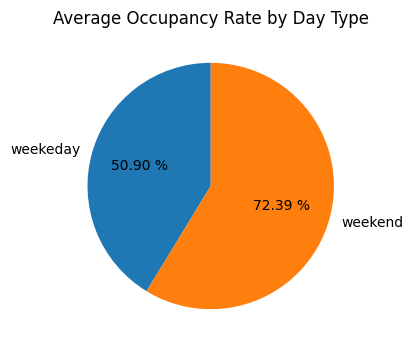

In [61]:
#plooting this on pie chart
#custom autopct function to show actual values
def absolute_values(val):
    return f'{val/100*sum(df_dtype_avg):.2f} %'

# Plotting the pie chart
plt.figure(figsize=(4,4))
plt.pie(df_dtype_avg, labels=df_dtype_avg.index, autopct=absolute_values, startangle=90)
plt.title("Average Occupancy Rate by Day Type")
plt.show()

### 4. In the month of jine what is the occupancy rate of diffrent cities ?

In [62]:
# joining dim_ddate table
df_june_22=pd.merge(df_city,dim_date,left_on="check_in_date",right_on="date")
df_june_22.head()
#Filtering only june data
df_june_22=df_june_22[df_june_22["mmm yy"]=="Jun 22"]
df_june_22.head()
#calculating June occ_pct
df_june_22_avg=df_june_22.groupby("city")["occ_pct"].mean().round(2)
df_june_22_avg

city
Bangalore    56.58
Delhi        62.47
Hyderabad    58.46
Mumbai       58.38
Name: occ_pct, dtype: float64

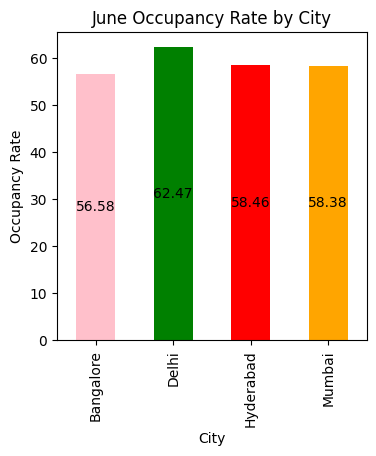

In [63]:
#plotting this in bar chart
plt.figure(figsize=(4,4))
df_june_22_avg.plot(kind="bar",color= ["pink", "Green", "Red", "Orange"])

plt.xlabel("City")  
plt.ylabel("Occupancy Rate")
plt.title("June Occupancy Rate by City")

                    #adding data labels

for index, values in enumerate(df_june_22_avg):
    plt.text(index, values / 2, f'{values:.2f}', ha="center", va="center", color="black", fontsize=10)

plt.show()

### 5.print revenue realized per city

In [64]:
#joining dim_hotels with fact_booking as dim_hotels contains city
df_rev = pd.merge(fact_bookings,dim_hotels,on="property_id")
df_rev
# calculating revenue realized per city
df_rev_sum=df_rev.groupby("city")["revenue_realized"].sum()
df_rev_sum

city
Bangalore    420383550
Delhi        294404488
Hyderabad    325179310
Mumbai       668569251
Name: revenue_realized, dtype: int64

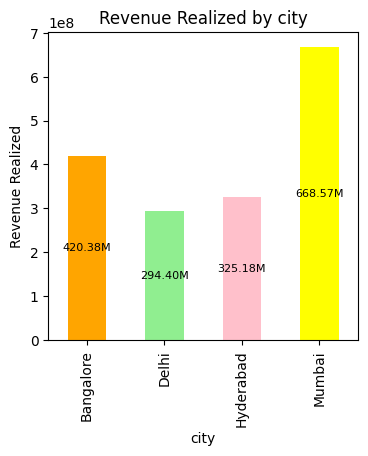

In [65]:
#plotting this on bar chart 
plt.figure(figsize=(4,4))
df_rev_sum.plot(kind="bar",color= ["orange", "lightgreen", "pink", "yellow"])
plt.xlabel("city")
plt.ylabel("Revenue Realized")
plt.title("Revenue Realized by city")

                    #adding data labels

for index, values in enumerate(df_rev_sum):
    plt.text(index, values / 2, f'{values/1000000:.2f}{"M"}', ha="center", va="center", color="black", fontsize=8)

plt.show()

### 6.print month by month revenue

In [66]:
#data is in object datatype, lets convert it to datatime
dim_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      92 non-null     object
 1   mmm yy    92 non-null     object
 2   week no   92 non-null     object
 3   day_type  92 non-null     object
dtypes: object(4)
memory usage: 3.0+ KB


In [67]:
dim_date["date"]=pd.to_datetime(dim_date["date"],errors="coerce")
dim_date.head()

C:\Users\hrishi\AppData\Local\Temp\ipykernel_12308\1296747481.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dim_date["date"]=pd.to_datetime(dim_date["date"],errors="coerce")


,date,mmm yy,week no,day_type
0,2022-05-01,May 22,W 19,weekend
1,2022-05-02,May 22,W 19,weekeday
2,2022-05-03,May 22,W 19,weekeday
3,2022-05-04,May 22,W 19,weekeday
4,2022-05-05,May 22,W 19,weekeday


In [68]:
# Let change the check_in_date type also
fact_bookings["check_in_date"]=pd.to_datetime(fact_bookings["check_in_date"],errors="coerce")
fact_bookings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134573 entries, 1 to 134589
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   booking_id         134573 non-null  object        
 1   property_id        134573 non-null  int64         
 2   booking_date       134573 non-null  object        
 3   check_in_date      55790 non-null   datetime64[ns]
 4   checkout_date      134573 non-null  object        
 5   no_guests          134573 non-null  float64       
 6   room_category      134573 non-null  object        
 7   booking_platform   134573 non-null  object        
 8   ratings_given      56676 non-null   float64       
 9   booking_status     134573 non-null  object        
 10  revenue_generated  134573 non-null  int64         
 11  revenue_realized   134573 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 13.3+ MB


In [69]:
# let now join both the table
df_MOM=pd.merge(fact_bookings,dim_date,left_on="check_in_date",right_on="date")
df_MOM

#calculating MOM revenue
df_MOM_rev=df_MOM.groupby("mmm yy")["revenue_realized"].sum().sort_values(ascending=False)
df_MOM_rev



mmm yy
May 22    60961428
Jul 22    60278496
Jun 22    52903014
Name: revenue_realized, dtype: int64

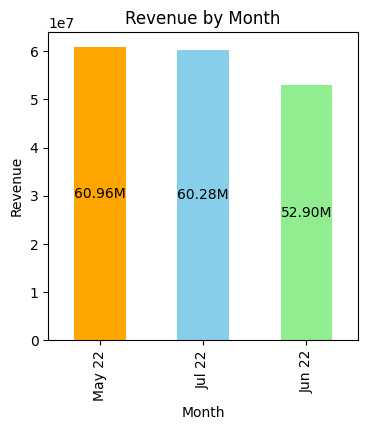

In [70]:
#plotting this on bar chart 
plt.figure(figsize=(4,4))
df_MOM_rev.plot(kind="bar",color=["orange","skyblue","lightgreen"])
plt.title("Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Revenue")

#adding data labels
for index,values in enumerate(df_MOM_rev):
     plt.text(index, values / 2, f'{values/1000000:.2f}{"M"}', ha="center", va="center", color="black", fontsize=10)

plt.show()

### 7.Print revenue realized per hotel type

In [71]:
df_rev_cat=df_rev.groupby("category")["revenue_realized"].sum()
df_rev_cat

category
Business     655967037
Luxury      1052569562
Name: revenue_realized, dtype: int64

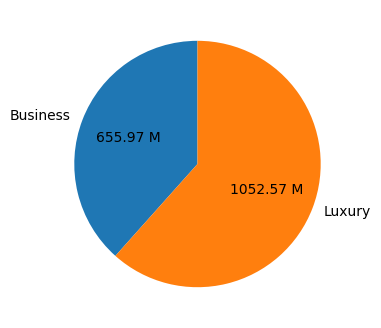

In [72]:
#plotting this on pie chart
def absolute_values(val):
    return f'{val/100*sum(df_rev_cat)/1000000:.2f} {"M"}'
plt.figure(figsize=(4,4))
plt.pie(df_rev_cat, labels=df_rev_cat.index, autopct=absolute_values, startangle=90)
plt.show()

### 8.What is the average rating per city

In [73]:
df_rating_avg=df_rev.groupby("city")["ratings_given"].mean().round(2)
df_rating_avg

city
Bangalore    3.41
Delhi        3.78
Hyderabad    3.66
Mumbai       3.65
Name: ratings_given, dtype: float64

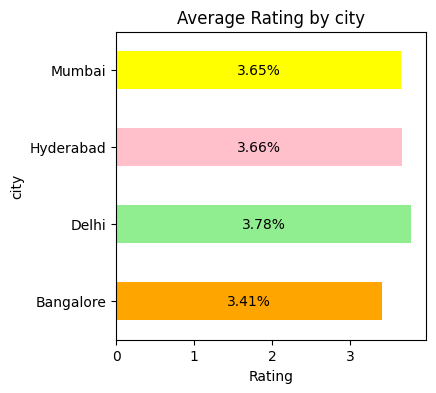

In [74]:
#plotting this on pie chart
plt.figure(figsize=(4,4))
df_rating_avg.plot(kind="barh",color= ["orange", "lightgreen", "pink", "yellow"])
plt.xlabel("Rating")
plt.ylabel("city")
plt.title("Average Rating by city")

#adding data labels

for index,values in enumerate(df_rating_avg):
     plt.text(values / 2,index, f'{values:.2f}{"%"}', ha="center", va="center", color="black", fontsize=10)

plt.show()


### 9.What is the revenue realized per booking platform ?

In [75]:
df_rev.head()

,booking_id,property_id,booking_date,check_in_date,checkout_date,no_guests,room_category,booking_platform,ratings_given,booking_status,revenue_generated,revenue_realized,property_name,category,city
0,May012216558RT12,16558,30-04-22,1/5/2022,2/5/2022,2.0,RT1,others,NaN,Cancelled,9100,3640,Atliq Grands,Luxury,Delhi
1,May012216558RT15,16558,27-04-22,1/5/2022,2/5/2022,4.0,RT1,direct online,5.0,Checked Out,10920,10920,Atliq Grands,Luxury,Delhi
2,May012216558RT16,16558,1/5/2022,1/5/2022,3/5/2022,2.0,RT1,others,4.0,Checked Out,9100,9100,Atliq Grands,Luxury,Delhi
3,May012216558RT17,16558,28-04-22,1/5/2022,6/5/2022,2.0,RT1,others,NaN,Cancelled,9100,3640,Atliq Grands,Luxury,Delhi
4,May012216558RT18,16558,26-04-22,1/5/2022,3/5/2022,2.0,RT1,logtrip,NaN,No Show,9100,9100,Atliq Grands,Luxury,Delhi


In [76]:
# calculating revenue by booking platfroms
df_rev_bp=df_rev.groupby("booking_platform")["revenue_realized"].sum()
df_rev_bp

booking_platform
direct offline     86374933
direct online     168948637
journey           102531334
logtrip           187494028
makeyourtrip      340814104
others            699306762
tripster          123066801
Name: revenue_realized, dtype: int64

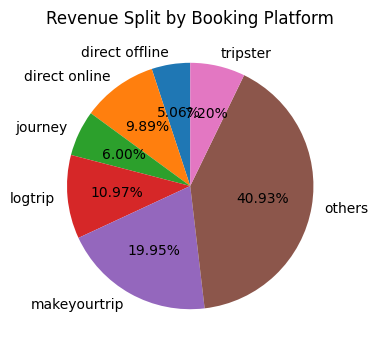

In [77]:
#plotting this on pie chart
plt.figure(figsize=(4,4))
plt.pie(df_rev_bp,labels=df_rev_bp.index,autopct="%1.2f%%",startangle=90)
plt.title("Revenue Split by Booking Platform")

#def absolute_value(val):
# return f'{val/100*sum(df_rev_bp)/1000000:.2f}{"M"}' for showing absolute values
plt.show()

### 10.What is the booking cancelation rate

In [78]:
fact_bookings.head()

,booking_id,property_id,booking_date,check_in_date,checkout_date,no_guests,room_category,booking_platform,ratings_given,booking_status,revenue_generated,revenue_realized
1,May012216558RT12,16558,30-04-22,2022-01-05,2/5/2022,2.0,RT1,others,NaN,Cancelled,9100,3640
4,May012216558RT15,16558,27-04-22,2022-01-05,2/5/2022,4.0,RT1,direct online,5.0,Checked Out,10920,10920
5,May012216558RT16,16558,1/5/2022,2022-01-05,3/5/2022,2.0,RT1,others,4.0,Checked Out,9100,9100
6,May012216558RT17,16558,28-04-22,2022-01-05,6/5/2022,2.0,RT1,others,NaN,Cancelled,9100,3640
7,May012216558RT18,16558,26-04-22,2022-01-05,3/5/2022,2.0,RT1,logtrip,NaN,No Show,9100,9100


In [79]:
total_bookings=fact_bookings.shape[0] #this will count the total no.of rows
cancelled_bookings=fact_bookings[fact_bookings["booking_status"]=="Cancelled"]
cancelled_count=cancelled_bookings.shape[0] #this will count the cancelled rows

Booking_cancellation_rate=(cancelled_count/total_bookings)*100
Booking_cancellation_rate

24.831132545161363

The Booking Cancellation Rate is 24.83 % for AtliQ Grands